# Проверка гипотез для увеличения выручки интернет-магазина

### Введение

В моем распоряжении есть список гипотез с расчитанными показателями охвата, влияния, уверенности и затрат, данные о заказах с идентификаторами пользователей, датами и стоимостью, а также распределение пользователей из каждой группы А/B теста по датам.

В этом проекте необходимо:
- Приоритизировать гипотезы
- Подготовить данные для А/В-теста
- Провести А/В-тест 
- Сделать выводы

### Просмотр и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import scipy.stats as stats


In [2]:
try:
    df = pd.read_csv('/Users/janna/Documents/Учеба/hypothesis.csv')
    orders = pd.read_csv('/Users/janna/Documents/Учеба/orders.csv')
    visitors = pd.read_csv('/Users/janna/Documents/Учеба/visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
display(df)
pd.options.display.max_colwidth = 100
display(orders.head())
display(visitors.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
#делаю название столбцов строчными для удобства
df.columns = df.columns.str.lower()


In [5]:
df.info()
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

In [6]:
#Меняю формат дат
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)


In [7]:
#проверяю на явные дубликаты
print(visitors.duplicated().sum())
print(orders.duplicated().sum())
print(df.duplicated().sum())

0
0
0


In [8]:
#проверяю на пропуски
print(visitors.isna().sum())
print(orders.isna().sum())
print(df.isna().sum())

date        0
group       0
visitors    0
dtype: int64
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отличная предобработка </div>

<b>Итого</b> у нас три датафрейма без пропусков и дубликатов. 9 гипотез, 1197 запись о покупках и 62 даты с количеством пользователей каждой группы теста

### Часть. Приоритизация гипотез.

Чтобы приоритезировать гипотезы и выбрать те, которые точно следуюет протестировать, применим фреймворки ICE и RICE. <br> Для расчета ICE мы определяем:
- Насколько сильно изменения повлияют на пользователей и их удовлетворенность
- Насколько мы уверены, что действие повлияет именно так
- Сколько стоит протестировать эту гипотезу.

А для расчета RICE добавляем в формулу еще одно значение:
- Скольких пользователей затронет изменение, которое мы хотим реализовать.

В итоге у нас получится список проранжированных гипотез, у которых баллы выставлены в соответсвии с перемноженными показателями выше, что даст возможность в первую очередь тестировать самые полезные гипотезы.

#### Применение фреймворка ICE

In [9]:
df['ICE'] = round(df['impact'] * df['confidence'] / df['efforts'],1)
display(df[['hypothesis','ICE']].sort_values(by='ICE', ascending = False))
pd.set_option('max_colwidth',100)


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


<b>Вывод:</b> По результатам этого метода, наиболее перспективным являются гипотезы номер 8 - <i>Запустить акцию, дающую скидку на товар в день рождения</i>, 0 - <i>Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей<i> и 7 - <i>Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	</i>




#### Применение фреймворка RICE

In [10]:
df['RICE'] = df['reach'] * df['impact'] * df['confidence'] / df['efforts']
display(df[['hypothesis','RICE']].sort_values(by='RICE', ascending = False))
pd.set_option('max_colwidth',100)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<b>Вывод:</b> По результатам метода RICE, наиболее перспективной гипотезой является номер 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Самая популярная в прошлом методе гипотеза номер 8 опустилась в этом методе на пятое место, что объясняется охватом пользователей. В короткий период проведения тестов дни рождения произойдут у маленькой части всех клиентов.
При этом две другие популярные гипотезы из метода ICE 7 и 0 так же получили высокую оценку.
И в топ добавилась гипотеза 6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию, так как у нее тоже большое влияние имеет охват пользователей, главную страницу и баннер на ней будут видеть все.


### Часть. Анализ A/B-теста

#### Проверка данных

In [11]:
#проверяем, попадают ли какие-то пользователи в обе группы
groupA1 = orders[orders['group'] == 'A'][['group', 'visitorId']]
groupB1 = orders[orders['group'] == 'B'][['group', 'visitorId']]

#сводная с пользователями в обеих группах
s1 = pd.merge(groupA1, groupB1, how='inner', on=['visitorId']).nunique()

print('Дата начала теста', orders['date'].min())

print('Дата окончания теста', orders['date'].max())

print('Пользователей в группе А', groupA1['visitorId'].nunique())

print('Пользователей в группе В', groupB1['visitorId'].nunique())

print('Пересекающиеся пользователи в обеих группах', s1['visitorId'])

print('Доля пересекающихся пользователей от общего количества пользователей', round(s1['visitorId']/(groupA1['visitorId']\
      .nunique()+groupB1['visitorId'].nunique()),3))




Дата начала теста 2019-08-01 00:00:00
Дата окончания теста 2019-08-31 00:00:00
Пользователей в группе А 503
Пользователей в группе В 586
Пересекающиеся пользователи в обеих группах 58
Доля пересекающихся пользователей от общего количества пользователей 0.053


В тестируемых группах А и В 503 и 586 уникальных пользователей соответственно.<br>
Получилось, что у нас в обеих группах есть 58 уникальных пользователей. Это занимает 5,3% от общего количества уникальных пользователей, поэтому не должно исказить результаты теста.<br>
Данные для теста есть в интервале с 1 по 31 августа 2019 года.<br>
Всего две группы тестирования. 


#### График кумулятивной выручки по группам

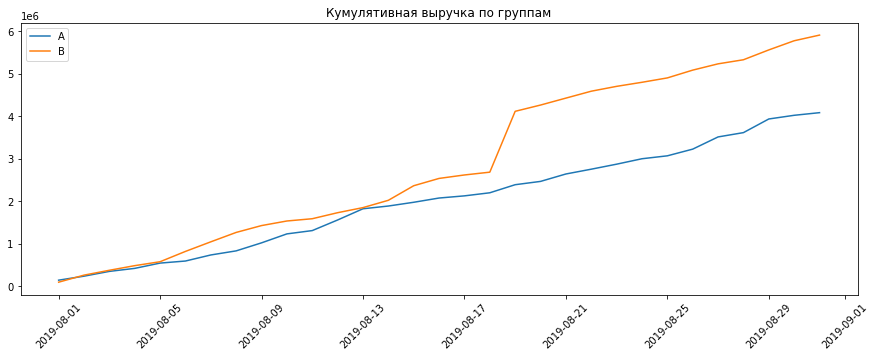

In [12]:
# создаем уникальные пары дата-группа
datesGroups = orders[['date','group']].drop_duplicates()

#собираем в одну таблицу
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

#агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = (datesGroups.
                      apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
     .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
)

#создаем переменную, объединяя предыдущие данные с переименованием столбцов
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']) 
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#график выручки А и В
plt.figure(figsize=(15,5))
plt.xticks(rotation= 45)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title(label= "Кумулятивная выручка по группам") 
plt.legend() 
plt.show()


Выручка увеличивается равномерно, но в середине месяца есть резкий всплеск в группе В. Возможно, были резкие повышения количества заказов или непривычно большие средние чеки в покупках

#### График кумулятивного среднего чека по группам

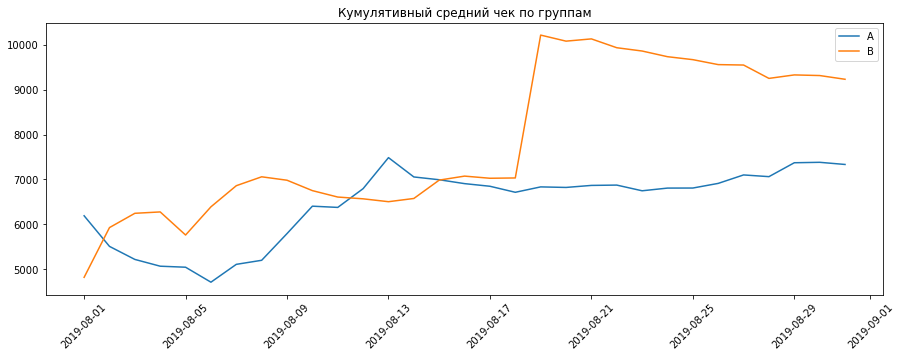

In [13]:
plt.figure(figsize=(15,5))
plt.xticks(rotation= 45)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title(label= "Кумулятивный средний чек по группам") 
plt.legend() 
plt.show()

Средний чек по группам растет. При этом в группе В также есть резкий рост. Средний чек в группе В резко вырос и минимально снижался, так и не достигнув начальных показателей.

#### График относительного изменения кумулятивного среднего чека группы B к группе A.

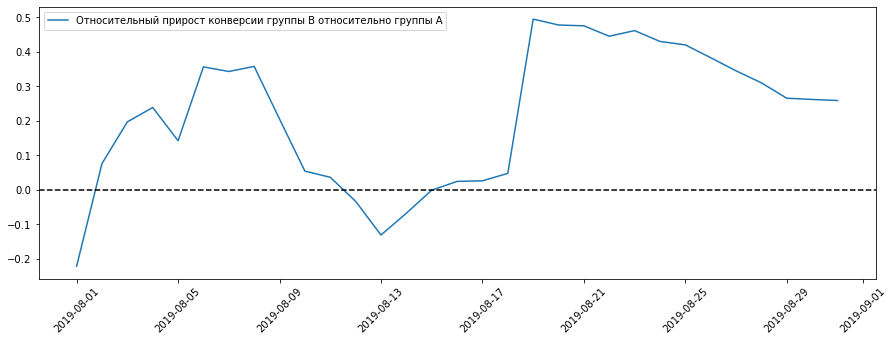

In [14]:
#сводная с кумулятивной выручкой и количеством заказов у обеих групп
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', \
                                                   right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,5))
plt.xticks(rotation= 45)

plt.plot(mergedCumulativeRevenue['date'], \
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,\
        label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


Был спад, но в целом относительный прирост положительный

#### График кумулятивного среднего количества заказов по группам

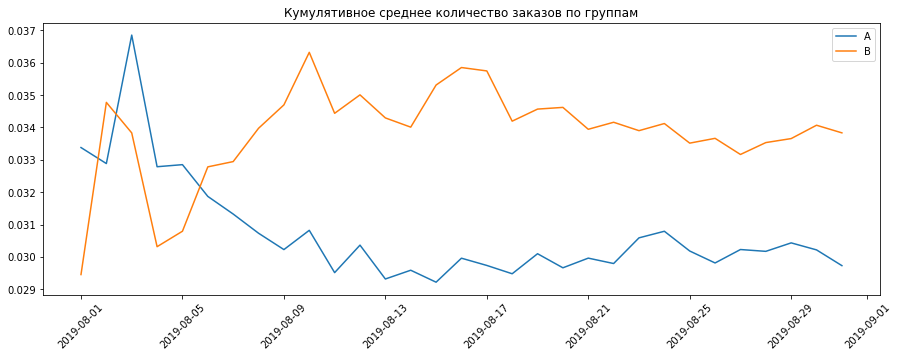

In [15]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title(label= "Кумулятивное среднее количество заказов по группам") 
plt.legend()
plt.xticks(rotation= 45)
plt.show()


График получился несимметричный. Среднее количество заказов у группы В вышло вперед и зафиксировалось примерно на этом уровне, больше не опускаясь ниже А.

#### График относительного изменения кумулятивного количества заказов группы B к группе A

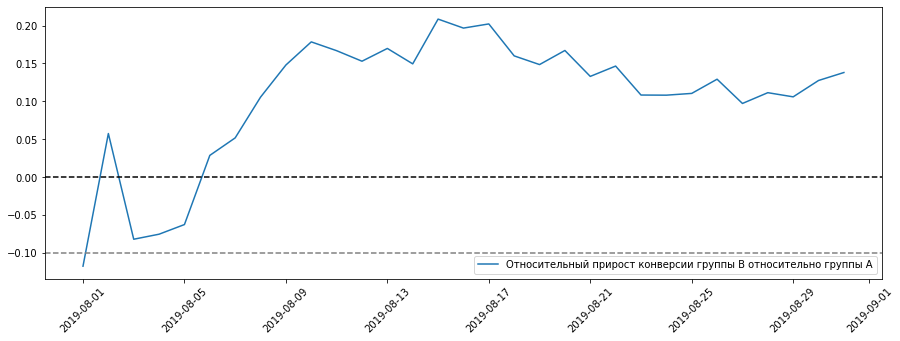

In [16]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15,5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation= 45)
plt.show()

В начале среднее количество группы В было ниже, потому был резкий скачок и установление примерно на одном уровне. 

#### Точечный график количества заказов по пользователям

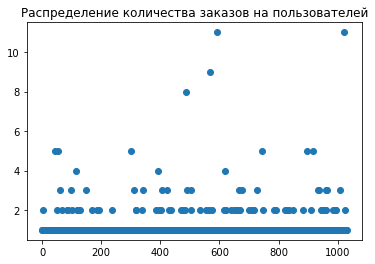

In [17]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']


x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title(label= "Распределение количества заказов на пользователей") 
plt.show()


На графике видно, что основная часть покупателей совершила по одному заказу, большая часть по два заказа и небольшие группы пользователей сделали по 3-5 заказов. Также есть выбросы и нетипичные значения, когда у пользователей более 8 заказов.

#### Расчет 95-й и 99-й перцентилей количества заказов на пользователя

In [18]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Получается, что 95% покупателей совершает до двух заказов и лишь 1% делает 4 и более

#### Точечный график стоимости заказов

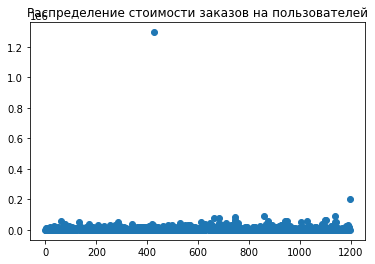

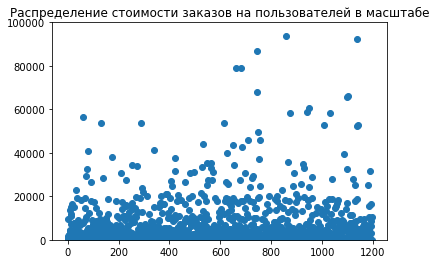

In [19]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title(label= "Распределение стоимости заказов на пользователей") 

plt.show()

#второй график в другом масштабе для наглядности
plt.scatter(x_values, orders['revenue']) 
plt.title(label= "Распределение стоимости заказов на пользователей в масштабе") 

plt.ylim(0,100000)
plt.show()



На графике явно видно выбросы. Основная часть данных находится в пределах 20000 у.е, тогда как есть выбросы свыше 40000 у.е и точечные значения свыше 80000 у.е, и явно аномальное значение на свыше 1200000 у.е

#### Расчет 95-й и 99-й перцентилей стоимости заказов


In [20]:
print(np.percentile(orders['revenue'], [95,99])) 


[28000.  58233.2]


При расчете перцентелей мы видим примерно такую же картину. Получается, что 95% всех покупок - стоимостью в пределах 28000 у.е. и лишь 1% - свыше 58000 у.е



#### Cтатистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

Нулевая гипотеза: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.


In [21]:
#группируем количество посетителей по датам в группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

#кумулятивные значения количества посетителей
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
#группируем количество посетителей по датам в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#кумулятивные значения количества посетителей
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#группировка по датам количества заказов и выручки по группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#кумулятивные данные по количеству заказов и выручке по группе А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#группировка по датам количества заказов и выручки по группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#кумулятивные данные по количеству заказов и выручке по группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#объединение в один датафрейм
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5)) 



,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Статистическая значимость различия в среднем количестве заказов между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [22]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [23]:
#создание объекта pd.Series нужной длины
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

sampleA = (pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                               name='orders')],axis=0))

sampleB = (pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                               name='orders')],axis=0))

In [24]:
print('pvalue', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительный прирост', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

pvalue 0.017
Относительный прирост 0.138


По сырым данным есть различия в среднем числе заказов групп А и В. По результатам получилось, что 0.017 меньше 0.05, значит, нулевую гипотезу о том, что статистически значимых различий нет, отвергаем. Можно с высокой степенью уверенности утверждать, что наблюдаемая разница между группами значима

При этом второй показатель указывает на прирост на 13.8% в группе В.

#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [25]:
print('pvalue','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']
                                          ['revenue'], orders[orders['group']=='B']['revenue'])[1]))
     
print('Относительный прирост','{0:.3f}'.format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue'].mean()-1))
     

pvalue 0.729
Относительный прирост 0.259


По результату pvalue больше 0,05. Значит, нет оснований отвергать гипотезу о том, что в среднем чеке между группами нет различий, тестируемые версии на основе собранных данных неразличимы

#### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил больше 2 заказов, так мы уберем 5% пользователей с наибольшим числом заказов. Также уберем пользователей со средним чеком свыше 30000, таким образом уберем до 5% пользователей с дорогими заказами

In [26]:
#сколько всего аномальных пользователей
maxOrders = 2
maxRevenue = 30000
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > maxOrders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > maxOrders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > maxRevenue]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
68


Всего 68 аномальных пользователей с высоким средним количеством заказов и высоким средним чеком

Нулевая гипотеза: различий в среднем количестве заказов между группами по очищенными данным нет. <br> Альтернативная: различия в среднем между группами по очищенным данным есть. 


In [27]:
#статистическая значимость различий в среднем количестве по очищенным данным

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders',),],axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],pd.Series(0,index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders',),],axis=0,
) 

print('pvalue','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

pvalue 0.013
Относительный прирост 0.172


Предыдущие результаты были 0.017 и 0.138. Данные практически не изменились.

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами с очищенными данными нет. <br> Альтернативная гипотеза: различия в среднем чеке между группами с очищенными данными есть.

In [28]:
print('pvalue','{0:.3f}'.format(stats.mannwhitneyu(orders[
                np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1])
)

print('Относительный прирост',"{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()- 1)
)

pvalue 0.720
Относительный прирост -0.023


Предыдущие показатели были 0.729 и 0.259. pvalue почти не изменился, а разница между сегментами изменилась более, чем на 25%

#### Решение по результатам теста

По результатам проведенного теста можно сделать выводы:

- По сырым и очищенным данным получилось, что в группах А и В есть различия в средних данных о количестве заказов. Показатель группы В выигрывает на 13-17%.
- По сырым и очищенным данным о среднем чеке в групах А и В нет статистически значимого различия ни до, ни после фильтрации аномалий.
- График отношения среднего количества заказов между группами говорит о том, что в группе В показатели стали лучше
- График отношения среднего чека так же говорит о том, что в группе В показатели резко увеличились и до уровня А больше не снижались.


Получается, что тест можно остановить и признать успешным, в группе В есть положительная динамика.